#Predicción de precios de casas utilizando Analisis Predictivo.

La finalidad de este proyecto es analizar las carácteristicas de diferentes casas ubicadas en California, estas caracteristicas son:

*   longitud: Medida de la distancia al oeste de una casa.
*   latitud: Medida de la distancia  al norte de una casa.
*   Edad media de la casa: Edad media de una casa que se encuentra dentro de una cuadra.
*   Habitaciones totales: Numero total de habitaciones que se encuentran dentro de una cuadra.
*   Dormitorios totales:Total de dormitorios que se encuentran en una cuadra.
*   Población: Número total de personas que se encuentran viviendo en una cuadra.
*   Hogares: Numero total de viviendas, con un grupo de personas en ellas, que se encuentran en una cuadra.
*   Media de ingresos: Valor medio de ingresos de los hogares que se encuentran en una cuadra, valorado en dolares.
*   Valor medio de la casa: Valor medio de las viviendas que se encuentran en una cuadra, valorado en dolares
*   Proximidad del océano: Distancia a la que se encuentra una casa del oceano.

#Librerias

In [145]:
#Se importan las dependencias
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.compose import ColumnTransformer

#Uso de Google Drive
En esta libreta se realizó una conexión con Google Drive para un uso sencillo y seguro, usando la instrucción **drive.mount** que nos ofrece colab.

In [83]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Comenzamos a cargar el dataset y observar sus datos.

In [111]:
#Se carga el Dataset
file_data = '/content/gdrive/MyDrive/Colab Notebooks/Tópicos Avanzados/Predict_House_Prices/housing.csv'
df = pd.read_csv(file_data)
#Observamos los datos organizados por filas
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [112]:
#Se muestran las categorías del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [114]:
#Se ignoran los valores vacíos
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


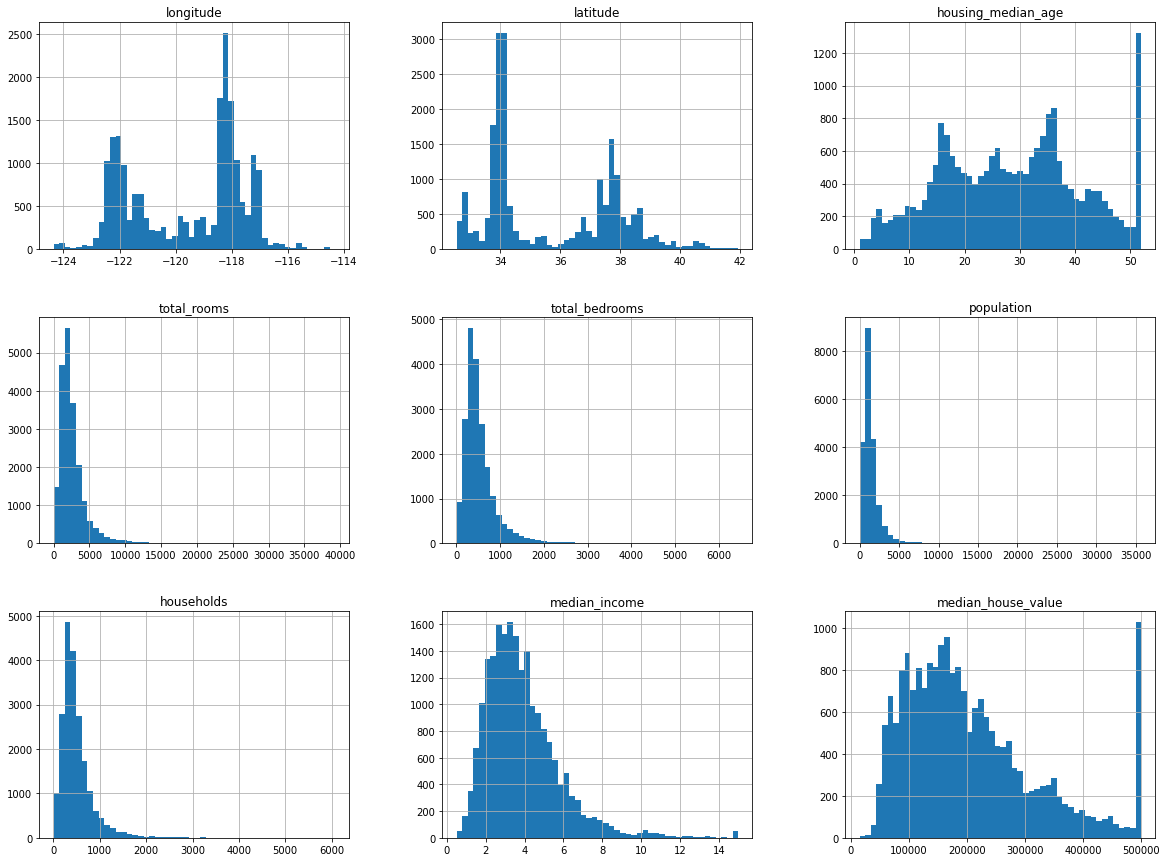

In [115]:
#Se crean los gráficos en base al conjunto de datos
df.hist(bins = 50, figsize = (20,15))
plt.show()

#Conjunto para pruebas

Creamos un conjunto de datos usando train_test_split de sklearn

In [142]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 0)

Para entender la estratificación usamos la siguiente función

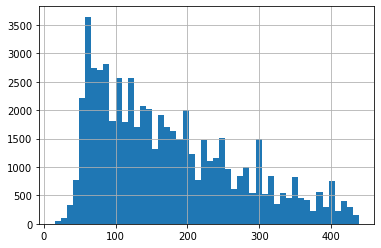

In [88]:
df["median_income"].hist(bins = 50)

Se crean las categorías de ingresos en casas

In [117]:
df = df[df['median_income'].notna()]
df["income_cat"] = pd.cut(df["median_income"],
      bins = [0., 1.5, 3.0, 4.5, 6, np.inf],
      labels = [1, 2, 3, 4, 5])

Se realiza la división estratificada

In [118]:
 split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 0)

for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [119]:
df["income_cat"].value_counts()/len(df)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

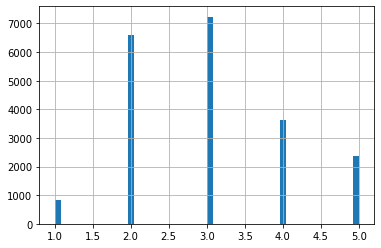

In [120]:
df["income_cat"].hist(bins = 50)

In [121]:
for dataset in (strat_train_set, strat_test_set, df):
    dataset.drop("income_cat", axis = 1, inplace = True)

In [122]:
df = strat_train_set.copy() #copia train_set

#Visualización de los datos

###Visualización Geográfica.
Se realiza un gráfico de dispersión itilizando el valor medio de la vivienda.

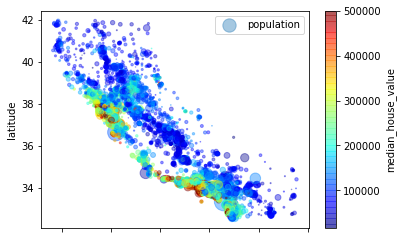

In [125]:
df.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
         s=df["population"]/100,label="population",
         c="median_house_value",cmap=plt.get_cmap("jet"),
         colorbar=True)
plt.legend()


###Busqueda de Correlaciones.

Se calcula el coeficiente R de Pearson

In [143]:
corr_matrix=df.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924918,-0.108133,0.041642,0.065226,0.097004,0.051889,-0.013306,-0.042943
latitude,-0.924918,1.000000,0.010790,-0.034414,-0.064452,-0.106866,-0.069643,-0.081483,-0.145757
housing_median_age,-0.108133,0.010790,1.000000,-0.359020,-0.317509,-0.293212,-0.300751,-0.113308,0.107227
total_rooms,0.041642,-0.034414,-0.359020,1.000000,0.929544,0.853603,0.918019,0.196317,0.137430
total_bedrooms,0.065226,-0.064452,-0.317509,0.929544,1.000000,0.874315,0.980162,-0.009378,0.053455
population,0.097004,-0.106866,-0.293212,0.853603,0.874315,1.000000,0.903793,0.003327,-0.023882
households,0.051889,-0.069643,-0.300751,0.918019,0.980162,0.903793,1.000000,0.011745,0.069089
median_income,-0.013306,-0.081483,-0.113308,0.196317,-0.009378,0.003327,0.011745,1.000000,0.688988
median_house_value,-0.042943,-0.145757,0.107227,0.137430,0.053455,-0.023882,0.069089,0.688988,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ea1137e50>,
      dtype=object)

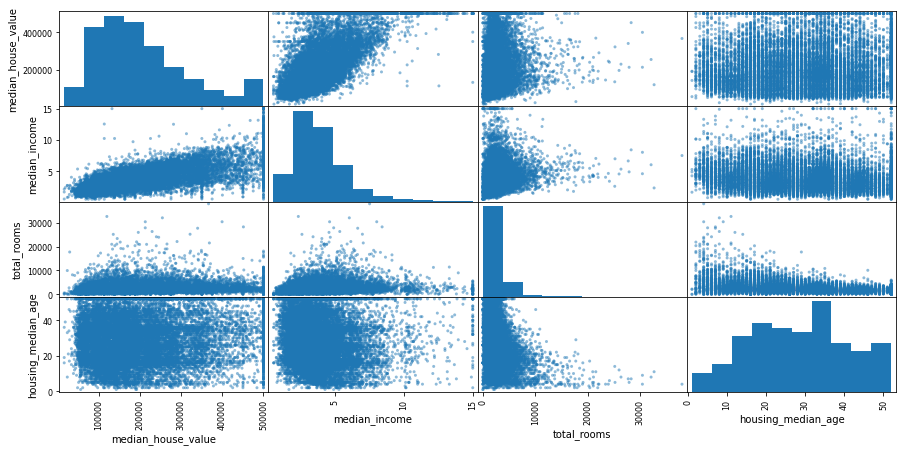

In [127]:
#Matriz de dispersión de pandas

attributes=["median_house_value","median_income","total_rooms","housing_median_age"]

scatter_matrix(df[attributes], figsize = (15,7))

#Preparación para algoritmos de aprendizaje.

Comenzamos por separar las etiquetas y predictores de nuestro conjunto de datos de entrenamiento original en copias que podemos usar.

In [128]:
housing=strat_train_set.drop("median_house_value",axis=1)
housing_labels=strat_train_set["median_house_value"].copy()

###Limpieza de los datos

Realizamos una limpieza en el dataset para eliminar los valores necesarios y establecer los valores que hagan falta.

In [129]:
# Utilizamos la librería SimpleImputer de sklearn.impute para los datos faltantes
imputer=SimpleImputer(strategy="median")

In [130]:
#Creamos una copia con los datos con características numéricas para usar el Imputer
housing_num=housing.drop("ocean_proximity",axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [131]:
# Observamos los valores del Imputer
imputer.statistics_

array([-118.49  ,   34.25  ,   29.    , 2129.    ,  436.    , 1167.    ,
        410.    ,    3.5343])

In [132]:
# Utilizamos el Imputer para realizar la transformación
X=imputer.transform(housing_num)

In [133]:
housing_tr=pd.DataFrame(X,columns=housing_num.columns)

In [134]:
housing_tr.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

Manejamos las variables de texto, en este caso "ocean_proximity" utilizando un LabelEncoder

In [135]:
encoder=LabelEncoder()
housing_cat=df["ocean_proximity"]
housing_cat_encoded=encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 3, ..., 0, 0, 4])

In [136]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

Como las clases no son ordinales, las codificamos utilizando OneHotEncoder

In [137]:
encoder=OneHotEncoder()
housing_cat_1hot=encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [138]:
#Convertimos la matriz dispersa en una matriz
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

###Transformación de columnas.

Para la transformación regular de las columnas podemos definir un transformador de columnas

In [144]:
rooms_ix,bedrooms_ix,population_ix,household_ix=3,4,5,6

class FeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room=add_bedrooms_per_room
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household=X[:,rooms_ix]/X[:,household_ix]
        population_per_household=X[:,population_ix]/X[:,household_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room=X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]

Usamos FunctionTransformer para definir la clade de FeatureAdder

In [140]:
from sklearn.preprocessing import FunctionTransformer

rooms_ix,bedrooms_ix,population_ix,household_ix=3,4,5,6

def extra_features(X,add_bedrooms_per_room=True):
    rooms_per_household=X[:,rooms_ix]/X[:,household_ix]
    population_per_household=X[:,population_ix]/X[:,household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

In [141]:
feature_adder =FunctionTransformer(extra_features,validate=False,
                                  kw_args={"add_bedrooms_per_room":False})
housing_extra_features =feature_adder.fit_transform(housing.values)

housing_extra_feat = pd.DataFrame(
    housing_extra_features,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_feat.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
19328,-122.87,38.48,27,3894,776,1832,715,3.5085,<1H OCEAN,5.44615,2.56224
4806,-118.34,34.02,49,1609,371,896,389,2.5156,<1H OCEAN,4.13625,2.30334
15645,-122.42,37.79,52,3364,1100,2112,1045,2.1343,NEAR BAY,3.21914,2.02105
2975,-119.08,35.32,8,11609,2141,5696,2100,5.0012,INLAND,5.5281,2.71238
18823,-121.62,41.78,40,3272,663,1467,553,1.7885,INLAND,5.91682,2.6528


###Transformación de Pipelines

Creamos las pipelines necesarias para su utilización en los diferentes modelos de predicción

In [146]:
num_attribs=list(housing_num)
cat_attribs=["ocean_proximity"]

num_pipeline=Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("feature_adder",FeatureAdder()),
    ("std_scaler",StandardScaler()),
])

full_pipeline=ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

In [ ]:
housing_prepared = full_pipeline.fit_transform(housing)

#Seleccion y entrenamiento del modelo.

Seleccionamos los metodos de predicción para entrenarlos

Comenzamos con el método de Regresión Lineal

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression()

In [ ]:
some_data=housing.iloc[:5]
some_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
19328,-122.87,38.48,27.0,3894.0,776.0,1832.0,715.0,3.5085,<1H OCEAN
4806,-118.34,34.02,49.0,1609.0,371.0,896.0,389.0,2.5156,<1H OCEAN
15645,-122.42,37.79,52.0,3364.0,1100.0,2112.0,1045.0,2.1343,NEAR BAY
2975,-119.08,35.32,8.0,11609.0,2141.0,5696.0,2100.0,5.0012,INLAND
18823,-121.62,41.78,40.0,3272.0,663.0,1467.0,553.0,1.7885,INLAND


In [ ]:
housing_labels.iloc[:5]

19328    187800.0
4806     136600.0
15645    400000.0
2975     106300.0
18823     43500.0
Name: median_house_value, dtype: float64

In [ ]:
some_prepared_data = full_pipeline.transform(some_data)

In [ ]:
lin_reg.predict(some_prepared_data)

array([227885.17864683, 199641.86684096, 250266.3411042 , 236655.89283764,
        11125.78759882])

Se prueba el método de error medio cuadrático

In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse= mean_squared_error(housing_labels,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68286.41923036716

Se prueba el método de Arbol de Decisión

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg=DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [ ]:
housing_predictions=tree_reg.predict(housing_prepared)
tree_mse= mean_squared_error(housing_labels,housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

El modelo anterior tiene un fallo el cuál es que se produce un overfit muy alto, debido a que recuerda los valores del conjunto en el entrenamiento.

#Evaluación con Cross Validation

Se usa el método de "Cross Validation" para realizar su evaluación.

In [ ]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(tree_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
rmse_scores=np.sqrt(-scores)

In [ ]:
rmse_scores

array([70555.1514905 , 73246.08510257, 70388.64919742, 69356.43473076,
       70386.06066862, 72349.65773576, 67853.88675194, 68084.43833107,
       70962.09984017, 69925.20617628])

Observamos los puntajes que nos arroja el método, y a partir de ellos obtenemos su media y su desviación estandar.

In [ ]:
def display_scores(scores):
    print("Scores:",scores)
    print("Mean:",scores.mean())
    print("Standard Deviation:",scores.std())

display_scores(rmse_scores)

Scores: [70555.1514905  73246.08510257 70388.64919742 69356.43473076
 70386.06066862 72349.65773576 67853.88675194 68084.43833107
 70962.09984017 69925.20617628]
Mean: 70310.76700250964
Standard Deviation: 1591.2594992980883


In [ ]:
lin_scores=cross_val_score(lin_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores=np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [65993.97246676 69010.24806374 71413.83112493 68742.95840851
 68937.97597951 66882.38169636 68302.97258028 66747.85112588
 69786.49966527 69063.19231501]
Mean: 68488.18834262605
Standard Deviation: 1515.8560925367422


Se prueba el método RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
rf_scores=cross_val_score(forest_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=5)
rf_rmse_scores=np.sqrt(-rf_scores)
display_scores(rf_rmse_scores)

Scores: [50050.4279923  51030.23350886 50459.61718594 50450.05692307
 51694.39745209]
Mean: 50736.94661245215
Standard Deviation: 571.5338020494632


#Afinación del Modelo

Se utiliza el método GridSearchCV para realizar un ajuste de hiperparámetros

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid={
    'n_estimators':[3,10,30],'max_features':[2,4,6,8],
    'bootstrap':[False,True],'n_estimators':[3,10],'max_features':[2,3,4],
}

forest_reg=RandomForestRegressor()
grid_search=GridSearchCV(forest_reg,param_grid,cv=5,scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [False, True], 'max_features': [2, 3, 4],
                         'n_estimators': [3, 10]},
             scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 10}

Obtenemos el mejor modelo en base a sus parametros

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_features=4, n_estimators=10)

Se muestran los puntajes obtenidos.

In [ ]:
cvres=grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score), params)

62595.26740493931 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54177.27012396192 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60624.08659389121 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52451.60093218204 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
58707.8126338268 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
51557.52211636268 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
62713.42469316644 {'bootstrap': True, 'max_features': 2, 'n_estimators': 3}
55690.33805901483 {'bootstrap': True, 'max_features': 2, 'n_estimators': 10}
60889.86197547585 {'bootstrap': True, 'max_features': 3, 'n_estimators': 3}
54193.70467330995 {'bootstrap': True, 'max_features': 3, 'n_estimators': 10}
60170.79703518623 {'bootstrap': True, 'max_features': 4, 'n_estimators': 3}
52627.66504687175 {'bootstrap': True, 'max_features': 4, 'n_estimators': 10}


Se muestran los resultados de los parametros en el Dataframe

In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.110076,0.004053,0.004751,0.000504,False,2,3,"{'bootstrap': False, 'max_features': 2, 'n_est...",-3.839931e+09,-3.991755e+09,-3.845617e+09,-3.771457e+09,-4.142077e+09,-3.918168e+09,1.330104e+08,11
1,0.340574,0.002177,0.013678,0.000338,False,2,10,"{'bootstrap': False, 'max_features': 2, 'n_est...",-2.789928e+09,-3.008115e+09,-2.851131e+09,-2.936767e+09,-3.089942e+09,-2.935177e+09,1.071783e+08,4
2,0.135436,0.006313,0.004253,0.000258,False,3,3,"{'bootstrap': False, 'max_features': 3, 'n_est...",-3.581876e+09,-3.704463e+09,-3.555639e+09,-3.780687e+09,-3.753734e+09,-3.675280e+09,9.072544e+07,9
3,0.454402,0.004803,0.014348,0.000650,False,3,10,"{'bootstrap': False, 'max_features': 3, 'n_est...",-2.671482e+09,-2.835116e+09,-2.680142e+09,-2.593275e+09,-2.975837e+09,-2.751170e+09,1.370025e+08,2
4,0.170623,0.003584,0.004973,0.000900,False,4,3,"{'bootstrap': False, 'max_features': 4, 'n_est...",-3.398639e+09,-3.394063e+09,-3.140870e+09,-3.577893e+09,-3.721572e+09,-3.446607e+09,1.956419e+08,7
5,0.552905,0.007223,0.014363,0.000679,False,4,10,"{'bootstrap': False, 'max_features': 4, 'n_est...",-2.649672e+09,-2.697147e+09,-2.590501e+09,-2.606898e+09,-2.746673e+09,-2.658178e+09,5.767532e+07,1
6,0.066750,0.003175,0.003573,0.000135,True,2,3,"{'bootstrap': True, 'max_features': 2, 'n_esti...",-4.022694e+09,-3.717313e+09,-3.978596e+09,-3.843842e+09,-4.102423e+09,-3.932974e+09,1.366004e+08,12
7,0.215618,0.005543,0.011314,0.000642,True,2,10,"{'bootstrap': True, 'max_features': 2, 'n_esti...",-3.083830e+09,-3.078312e+09,-3.083817e+09,-3.094288e+09,-3.166822e+09,-3.101414e+09,3.311072e+07,6
8,0.087514,0.003375,0.003759,0.000130,True,3,3,"{'bootstrap': True, 'max_features': 3, 'n_esti...",-3.658217e+09,-3.835609e+09,-3.740214e+09,-3.471331e+09,-3.832505e+09,-3.707575e+09,1.351392e+08,10
9,0.285249,0.005879,0.011317,0.000588,True,3,10,"{'bootstrap': True, 'max_features': 3, 'n_esti...",-2.800827e+09,-3.001326e+09,-2.906304e+09,-2.969560e+09,-3.006770e+09,-2.936958e+09,7.687794e+07,5


Análisis de los mejores modelos y sus errores

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.09156935, 0.08876003, 0.03907838, 0.0267792 , 0.01854103,
       0.02355467, 0.01860004, 0.21934728, 0.07136252, 0.0922774 ,
       0.11878784, 0.01792449, 0.16222028, 0.00028515, 0.0019028 ,
       0.00900954])

In [ ]:
# Visualización de las características
extra_features=["rooms_per_hhold","population_per_hhold","bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"] # Se llama al transformador desde el pipeline completo
cat_one_hot_features = list(cat_encoder.categories_[0])
features = num_attribs + extra_features + cat_one_hot_features

In [ ]:
sorted(zip(feature_importances, features), reverse=True)

[(0.21934727808067547, 'median_income'),
 (0.16222027828588162, 'INLAND'),
 (0.11878784150523265, 'bedrooms_per_room'),
 (0.09227740480174274, 'population_per_hhold'),
 (0.09156934908425673, 'longitude'),
 (0.08876002814524114, 'latitude'),
 (0.07136251789544999, 'rooms_per_hhold'),
 (0.03907837858932735, 'housing_median_age'),
 (0.026779195181504567, 'total_rooms'),
 (0.023554673481803116, 'population'),
 (0.018600044947724277, 'households'),
 (0.018541025787516603, 'total_bedrooms'),
 (0.01792448565946858, '<1H OCEAN'),
 (0.009009543947821795, 'NEAR OCEAN'),
 (0.001902803566008342, 'NEAR BAY'),
 (0.0002851510403450375, 'ISLAND')]

#Evaluación del sistema en el set de prueba.

In [ ]:
final_model= grid_search.best_estimator_

In [ ]:
X_test= strat_test_set.drop("median_house_value",axis=1)
y_test= strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [ ]:
final_predictions= final_model.predict(X_test_prepared)

In [ ]:
final_mse= mean_squared_error(y_test,final_predictions)
final_rmse=np.sqrt(final_mse)

In [ ]:
#Se muestra el resultado del método de Error cuadratico medio
final_rmse

49675.1480295315